# Minimal AI Feature API Rollup Example
This notebook is intended as a bare bones example to show a straightforward case of:

* Pulling a result from the AI Feature API
* Loading the json payload into a GeoDataFrame
* Visualising the result


In [84]:
from pathlib import Path
import os
import json
import sys

import pandas as pd
import shapely.wkt

sys.path.append("../")
from nearmap_ai.feature_api import FeatureApi
from nearmap_ai import constants, log, parcels

# Path to local API response cache
CACHE_DIR = Path("./cache")

# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

In [29]:
# Create instance of feature API to use existing python library
feature_api = FeatureApi(api_key=API_KEY, cache_dir=CACHE_DIR)

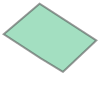

POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))


In [66]:
# Load a parcel boundary from test files
polygon = parcels.read_from_file(Path("../tests/data/test_parcels_2.csv")).iloc[5].geometry
display(polygon)
print(polygon)

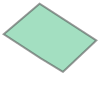

In [68]:
# Alternatively load your own boundary here
polygon = shapely.wkt.loads("POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))")
polygon

In [69]:
# Get the API payload for that polygon as a geodataframe
features_gdf, metadata_df, error_df = feature_api.get_features_gdf(polygon)

In [70]:
# Alternatively, load a payload from disk from your cache, or another source
with open("sample_payload.json", "r") as f:
    payload = json.load(f)
features_gdf, metadata_df = feature_api.payload_gdf(payload, 0)

<AxesSubplot:>

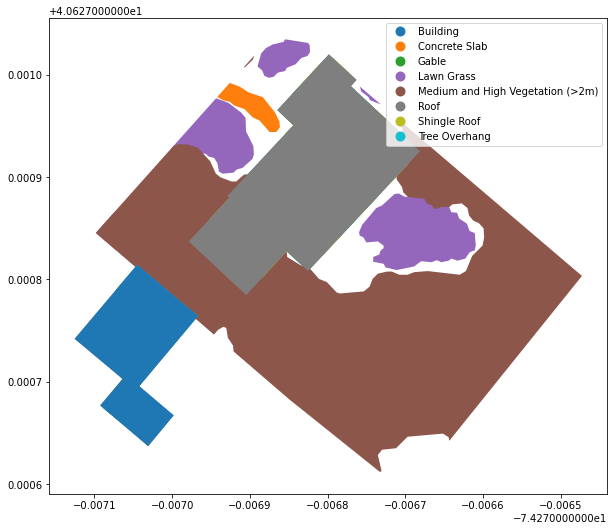

In [71]:
# Simple plot of features
features_gdf.plot("description", legend=True, figsize=(10,10))

In [72]:
# Filter out edge features based on default logic (ratios in parcel and minimum clipped areas)
filtered_features_gdf = parcels.filter_features_in_parcels(features_gdf)

<AxesSubplot:>

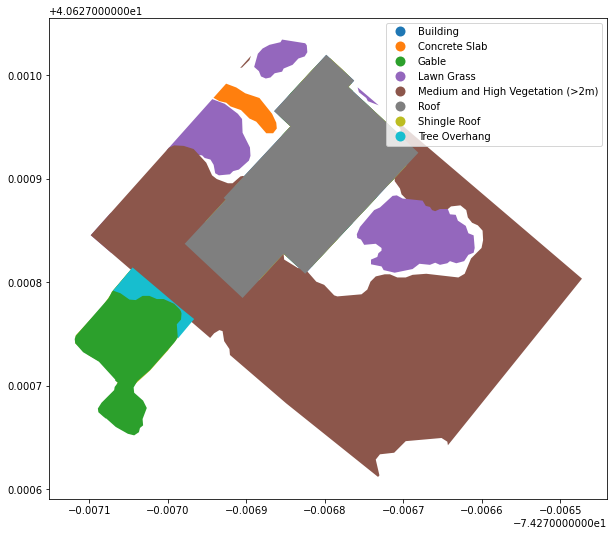

In [73]:
# Simple plot of features
filtered_features_gdf.plot("description", legend=True, figsize=(10,10))

In [1]:
import os
import shutil
from pathlib import Path
import logging
import random

from descartes import PolygonPatch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Local utilities
import sys
sys.path.append("../")
from nearmap_ai.feature_api import FeatureApi
from nearmap_ai import constants, log, parcels

# Logging level - set this to determine what level of info is returned. "DEBUG" adds timings for API responses.
log.configure_logger(logging.INFO)

# Display a bit more than the default pandas row and columns
pd.set_option("max_columns", 100)
pd.set_option("max_rows", 500)

# Path to local API response cache
CACHE_DIR = Path("./cache")

# Number of exampels to show
N_EXAMPLES = 10
random.seed(10)

### Which AI Packs and Feature Classes to use?

The following cell controls which class IDs are used (anything not in `ALL_USED_IDS` is ignored). It starts to look very cluttered with all packs, so a subset of these (`VISUALISATION_IDS`) is used for the visualisation of examples.

The source of truth for feature class IDs is the "classes.json" endpoint of the API, which can be refreshed periodically to add new feature class IDs to existing packs, update any changed descriptions, or reflect any new AI Packs added to your subscription.

### Date Restrictions
`SINCE` and `UNTIL` allow a generic restriction of dates. The latest published AI results within that time window will be returned.

In [2]:
# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

# Get pack codes from https://api.nearmap.com/ai/features/v4/packs.json
PACKS = [
    "building",
    "building_char",
    "roof_char",
    "solar",
    "construction",
    "trampoline",
    "pool",
    "vegetation",
    "surfaces",
]

ALL_USED_IDS = (
    [
        constants.BUILDING_ID, 
        constants.ROOF_ID, 
        constants.TRAMPOLINE_ID, 
        constants.POOL_ID, 
        constants.CONSTRUCTION_ID, 
        constants.SOLAR_ID
    ]
    + constants.VEG_IDS
    + constants.SURFACES_IDS
    + constants.ROOF_CHAR_IDS
)
VISUALISATION_IDS = [
    constants.BUILDING_ID,
    constants.ROOF_ID,
    constants.TRAMPOLINE_ID,
    constants.POOL_ID,
    constants.CONSTRUCTION_ID,
    constants.SOLAR_ID,
] + constants.VEG_IDS

# Data date range
SINCE, UNTIL = ("2016-01-01", "2022-12-31")

## FeatureApi

The `FeatureApi` class is used for interacting with the AI Feature API. The class takes care of caching (if configured), retrying and error handling, and concurrency.

In [3]:
# Create instance
feature_api = FeatureApi(api_key=API_KEY, cache_dir=CACHE_DIR)

In [4]:
# Get classes (this pulls data from https://api.nearmap.com/ai/features/v4/classes.json)
df_classes = feature_api.get_feature_classes().loc[ALL_USED_IDS, :]
df_classes.head(5)

,type,internalId,description,schema
id,,,,
a2e4ae39-8a61-5515-9d18-8900aa6e6072,Feature,1011,Building,NaN
c08255a4-ba9f-562b-932c-ff76f2faeeeb,Feature,1002,Roof,NaN
753621ee-0b9f-515e-9bcf-ea40b96612ab,Feature,1005,Trampoline,NaN
0339726f-081e-5a6e-b9a9-42d95c1b5c8a,Feature,1001,Swimming Pool,NaN
a2a81381-13c6-57dc-a967-af696e45f6c7,Feature,1004,Construction Site,NaN


### SHOULD I CLEAR THE CACHE?
WARNING: this clears the cache. PLEASE CONFIRM YOU HAVE STORED ANY PAYLOADS SAFELY PRIOR TO DOING THIS!!! Otherwise, you may lose data you have downloaded.

Cache is keyed by a hash of the request string (without the API key). If fresh AI results are published that correspond to the same parameter set, repeating the same pull (after deleting the cache) may have different results.


In [5]:
CLEAR_CACHE = False

if CLEAR_CACHE:
    shutil.rmtree(CACHE_DIR, ignore_errors=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

In [74]:
# Create instance of feature API to use existing python library
feature_api = FeatureApi(api_key=API_KEY, cache_dir=CACHE_DIR)

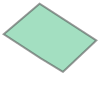

POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))


In [75]:
# Load a parcel boundary from test files
polygon = parcels.read_from_file(Path("../tests/data/test_parcels_2.csv")).iloc[5].geometry
display(polygon)
print(polygon)

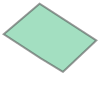

In [76]:
# Alternatively load your own boundary here
polygon = shapely.wkt.loads("POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))")
polygon

In [77]:
# Get the API payload for that polygon as a geodataframe
features_gdf, metadata_df, error_df = feature_api.get_features_gdf(polygon)

In [78]:
# Alternatively, load a payload from disk from your cache, or another source
with open("sample_payload.json", "r") as f:
    payload = json.load(f)
features_gdf, metadata_df = feature_api.payload_gdf(payload, 0)

<AxesSubplot:>

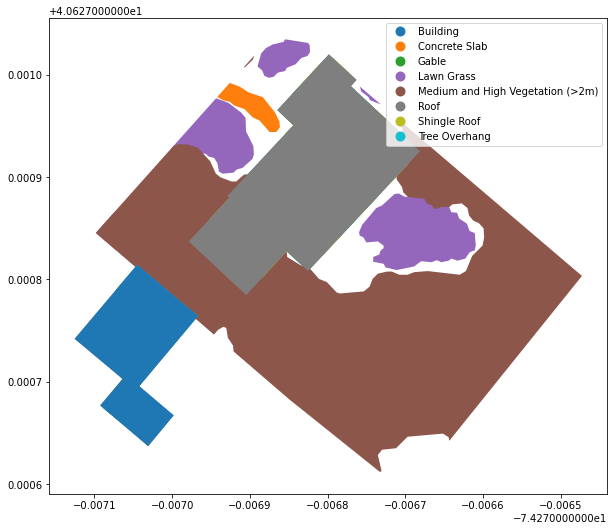

In [79]:
# Simple plot of features
features_gdf.plot("description", legend=True, figsize=(10,10))

In [81]:
# Filter out edge features based on default logic (ratios in parcel and minimum clipped areas)
filtered_features_gdf = parcels.filter_features_in_parcels(features_gdf)

<AxesSubplot:>

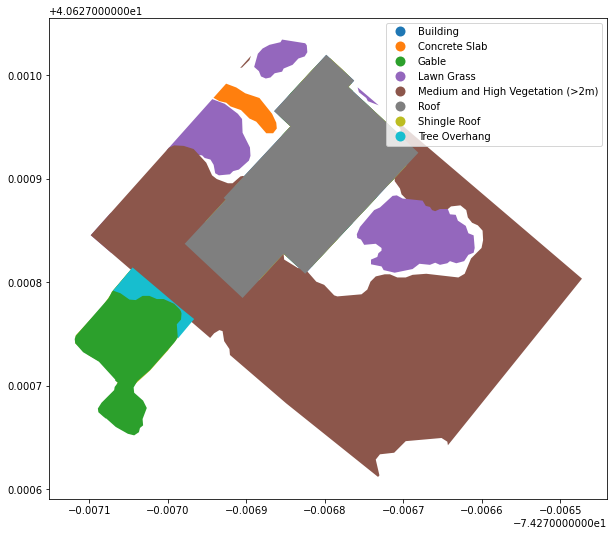

In [82]:
# Simple plot of features
filtered_features_gdf.plot("description", legend=True, figsize=(10,10))

# Create parcel rollup

Once we have the features in a parcel, all that remains is to flatten the features and attributes to tabular format. Note that roof and building values relate to the primary building and roof within a parcel. The primary building is defined as the building with the largest area within the parcel.

In [88]:
df_classes = pd.DataFrame([{"description": "Building"}], index=[constants.BUILDING_ID])
df_classes

,description
a2e4ae39-8a61-5515-9d18-8900aa6e6072,Building


In [90]:
rollup_df = parcels.feature_attributes(filtered_features_gdf, df_classes, "us", "largest_intersection")
rollup_df

{'building_present': 'Y',
 'building_count': 1,
 'building_total_area_sqft': 3132,
 'building_total_clipped_area_sqft': 3111,
 'building_total_unclipped_area_sqft': 3132,
 'building_confidence': 0.994140625,
 'primary_building_area_sqft': 3132,
 'primary_building_clipped_area_sqft': 3111,
 'primary_building_unclipped_area_sqft': 3132,
 'primary_building_confidence': 0.994140625,
 'primary_building_has_3d_attributes': 'Y',
 'primary_building_height_ft': 24.7,
 'primary_building_num_storeys_1_confidence': 0.5185629099256127,
 'primary_building_num_storeys_2_confidence': 0.4774573110445819,
 'primary_building_num_storeys_3+_confidence': 0.0039797790298054395}